# CPA攻击

这段代码展示了一个典型的相关功耗分析 (CPA) 攻击的实现过程，这是一种常见的侧信道攻击技术，特别用于破解密码系统。CPA攻击利用了设备在执行加密操作时的功耗泄漏，通过分析这些泄漏信息和假设操作的相关性，攻击者可以推断出加密密钥。以下是这段代码的关键步骤和方法：

# 假设功耗的计算：

对于每一个可能的密钥猜测值，代码计算了一个假设的功耗值，这些假设的功耗值基于明文和AES S盒的输出。首先通过异或操作将明文与密钥猜测值结合，然后查找对应的S盒输出，再计算该输出的汉明重量，作为假设功耗值。

# 相关性计算：

对每个密钥猜测值生成的假设功耗，代码计算了它与实际功耗泄漏的相关系数。这一步骤是CPA攻击的核心，因为理论上，当密钥猜测正确时，假设的功耗值与实际泄漏的相关性会最高。

# 结果可视化：

代码绘制了密钥猜测值与其最大相关系数之间的关系图，帮助识别相关系数最高的密钥猜测值。

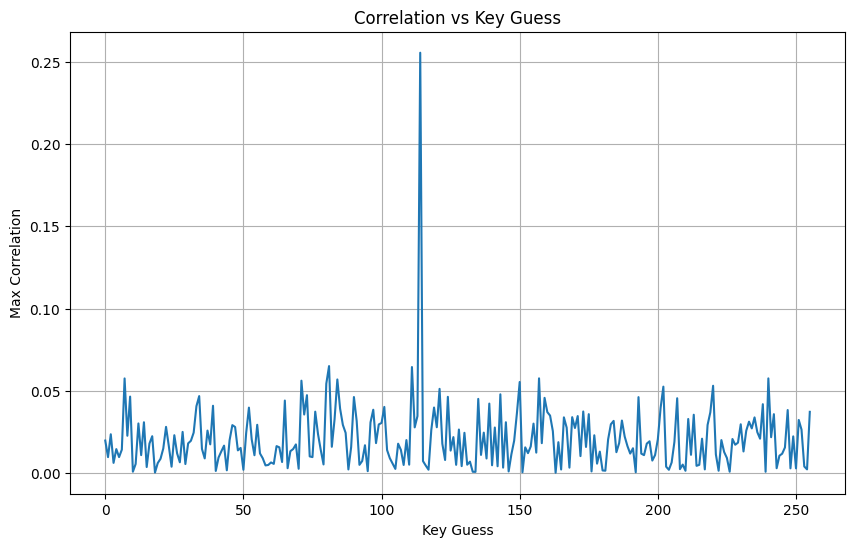

恢复的密钥字节（低噪声）：114


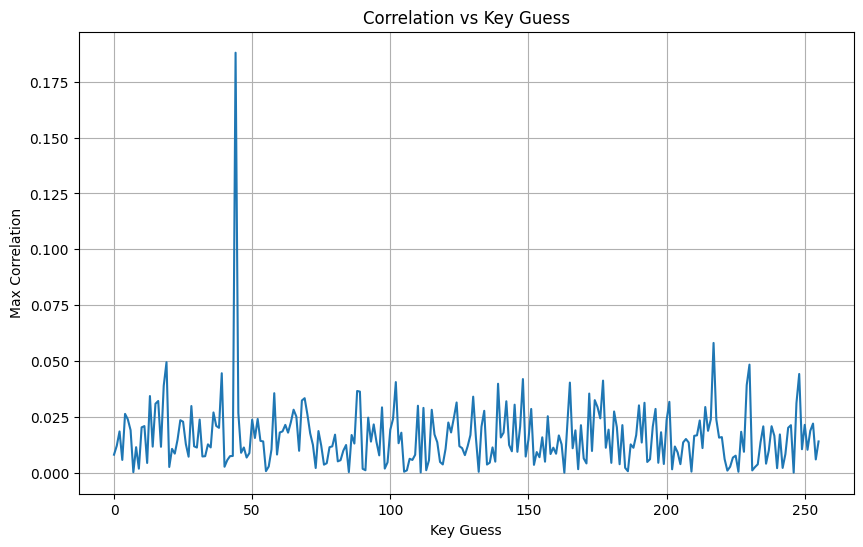

恢复的密钥字节（中噪声）：44


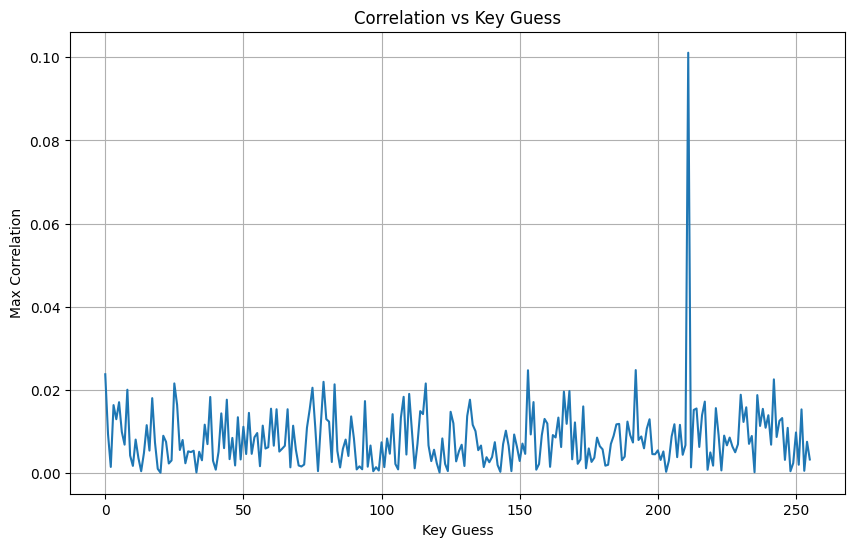

恢复的密钥字节（高噪声）：211


In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# 加载低噪声数据
plain_low = loadmat('plain_low.mat')['plain']
leakage_low = loadmat('leakage_low.mat')['leakage']

# 确保数据在0到255范围内
plain_low = plain_low % 256

# AES S盒
sbox = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]

# 汉明重量函数
def hamming_weight(n):
    return bin(n).count("1")

# 构建假设功耗函数
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        index = (plain[i, 0] ^ key_guess) % 256  # 确保索引在0-255范围内
        intermediate_value = sbox[index]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 计算相关性函数
def calculate_correlation(leakage, hypothetical):
    num_samples = leakage.shape[1]  # 获取每条功耗曲线的采样点数量
    correlation = np.zeros(num_samples)  # 初始化相关系数数组
    
    for i in range(num_samples):
        # 计算每个采样点的相关系数
        correlation[i] = pearsonr(leakage[:, i], hypothetical)[0]
    
    return correlation

# 绘制相关系数曲线函数
def plot_correlation(keys, correlations, title):
    plt.figure(figsize=(10, 6))
    plt.plot(keys, correlations)
    plt.title(title)
    plt.xlabel('Key Guess')
    plt.ylabel('Max Correlation')
    plt.grid(True)
    plt.show()

# 恢复密钥字节函数
def cpa_attack(plain, leakage):
    num_guesses = 256
    max_correlation = np.zeros(num_guesses)
    
    for key_guess in range(num_guesses):
        hypothetical = hypothetical_leakage(plain, key_guess)
        correlation = calculate_correlation(leakage, hypothetical)
        max_correlation[key_guess] = np.max(np.abs(correlation))
    
    best_guess = np.argmax(max_correlation)
    keys = np.arange(num_guesses)
    plot_correlation(keys, max_correlation, 'Correlation vs Key Guess')
    return best_guess

# 执行CPA攻击（低噪声）
recovered_key_low = cpa_attack(plain_low, leakage_low)
print(f'恢复的密钥字节（低噪声）：{recovered_key_low}')

# 加载中噪声数据
plain_medium = loadmat('plain_medium.mat')['plain']
leakage_medium = loadmat('leakage_medium.mat')['leakage']

# 确保数据在0到255范围内
plain_medium = plain_medium % 256

# 执行CPA攻击（中噪声）
recovered_key_medium = cpa_attack(plain_medium, leakage_medium)
print(f'恢复的密钥字节（中噪声）：{recovered_key_medium}')

# 加载高噪声数据
plain_high = loadmat('plain_high.mat')['plain']
leakage_high = loadmat('leakage_high.mat')['leakage']

# 确保数据在0到255范围内
plain_high = plain_high % 256

# 执行CPA攻击（高噪声）
recovered_key_high = cpa_attack(plain_high, leakage_high)
print(f'恢复的密钥字节（高噪声）：{recovered_key_high}')


Analyzing plain_low dataset


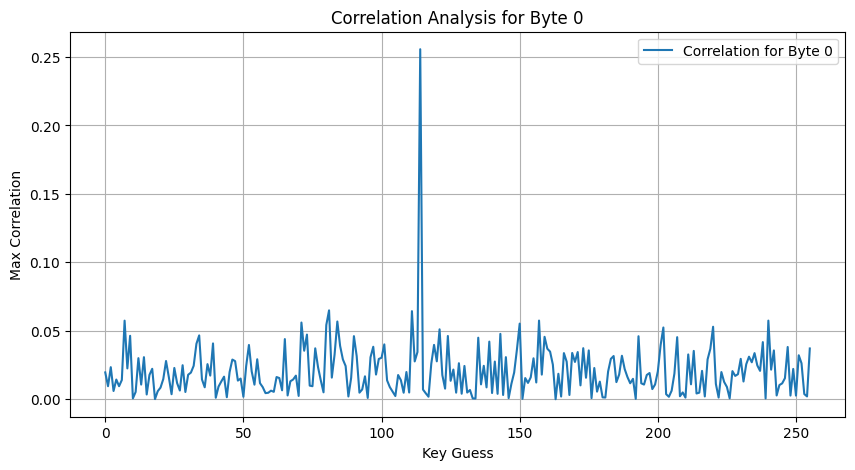

Recovered Key Byte 0: 114
Recovered AES Key for plain_low: [114]
Analyzing plain_medium dataset


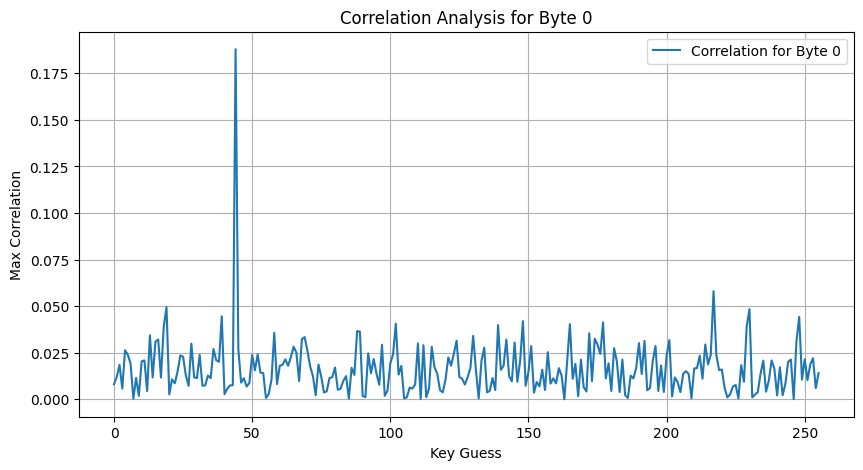

Recovered Key Byte 0: 44
Recovered AES Key for plain_medium: [44]
Analyzing plain_high dataset


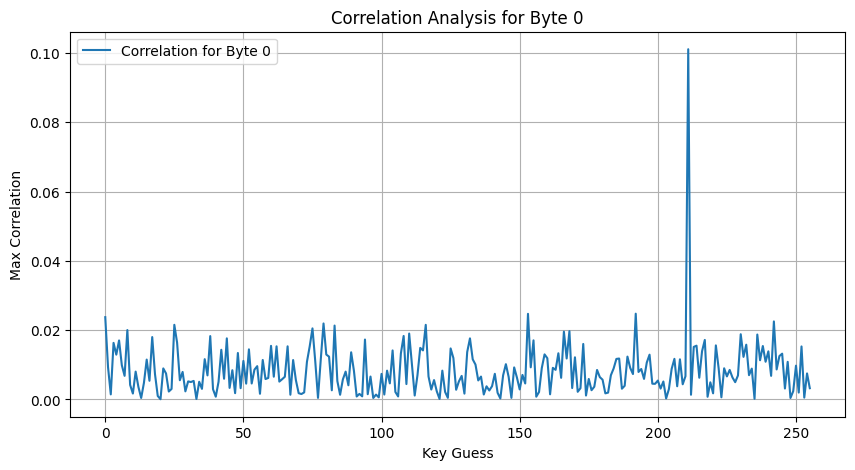

Recovered Key Byte 0: 211
Recovered AES Key for plain_high: [211]


In [2]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# AES S盒
sbox = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]

def hamming_weight(n):
    return bin(n).count("1")

def hypothetical_leakage(plain, key_guess, byte_index):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    for i in range(num_traces):
        index = (plain[i, byte_index] ^ key_guess) % 256
        intermediate_value = sbox[index]
        hypothetical[i] = hamming_weight(intermediate_value)
    return hypothetical

def calculate_correlation(leakage, hypothetical):
    num_samples = leakage.shape[1]
    correlation = np.zeros(num_samples)
    for i in range(num_samples):
        correlation[i], _ = pearsonr(leakage[:, i], hypothetical)
    return correlation

def cpa_attack(plain, leakage, byte_index):
    num_guesses = 256
    num_samples = leakage.shape[1]
    max_correlation = np.zeros(num_guesses)
    for key_guess in range(num_guesses):
        hypothetical = hypothetical_leakage(plain, key_guess, byte_index)
        correlation = calculate_correlation(leakage, hypothetical)
        max_correlation[key_guess] = np.max(np.abs(correlation))
    
    best_guess = np.argmax(max_correlation)
    
    plt.figure(figsize=(10, 5))
    plt.plot(max_correlation, label=f'Correlation for Byte {byte_index}')
    plt.xlabel('Key Guess')
    plt.ylabel('Max Correlation')
    plt.title(f'Correlation Analysis for Byte {byte_index}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_guess

def recover_full_key(plain, leakage):
    num_bytes = plain.shape[1]  # AES密钥通常为16字节
    key = []
    for byte_index in range(num_bytes):
        key_byte = cpa_attack(plain, leakage, byte_index)
        key.append(key_byte)
        print(f'Recovered Key Byte {byte_index}: {key_byte}')
    return key

# 加载并处理数据
data_path = ''  # 假设的数据路径
datasets = ['plain_low', 'plain_medium', 'plain_high']
leakages = ['leakage_low', 'leakage_medium', 'leakage_high']

for i, dataset in enumerate(datasets):
    plain = loadmat(data_path + dataset + '.mat')['plain']
    leakage = loadmat(data_path + leakages[i] + '.mat')['leakage']
    
    # 确保数据在0到255范围内
    plain = plain % 256
    if plain.ndim == 1:
        plain = plain.reshape(-1, 1)
    
    print(f"Analyzing {dataset} dataset")
    recovered_key = recover_full_key(plain, leakage)
    print(f'Recovered AES Key for {dataset}: {recovered_key}')

## 使用互信息进行能量分析攻击
互信息（Mutual Information）是一种衡量两个随机变量之间相互依赖程度的统计量。在侧信道分析中，我们可以使用互信息来衡量假设密钥和泄漏样本之间的关系，从而恢复密钥。以下展示如何使用互信息进行能量分析攻击以恢复AES密钥的第一个字节。

加载数据 (load_data): 此函数负责加载数据并确保明文数据被正确地模256处理，保证其值在0到255之间。

汉明重量计算 (hamming_weight): 计算整数的二进制表示中1的个数。

构建假设功耗 (hypothetical_leakage): 对于给定的密钥猜测，使用AES S盒和汉明重量生成假设的功耗泄漏。

计算互信息 (calculate_mutual_information): 使用KBinsDiscretizer对泄露数据进行离散化，并计算与假设泄露之间的互信息值。

执行MIA攻击 (mia_attack): 对所有可能的密钥进行遍历，计算每个密钥的互信息，并找到互信息最高的密钥作为最佳猜测。

绘制互信息曲线 (plot_mutual_information): 绘制密钥猜测与其对应的互信息值的图表，可视化每个密钥猜测的互信息强度。


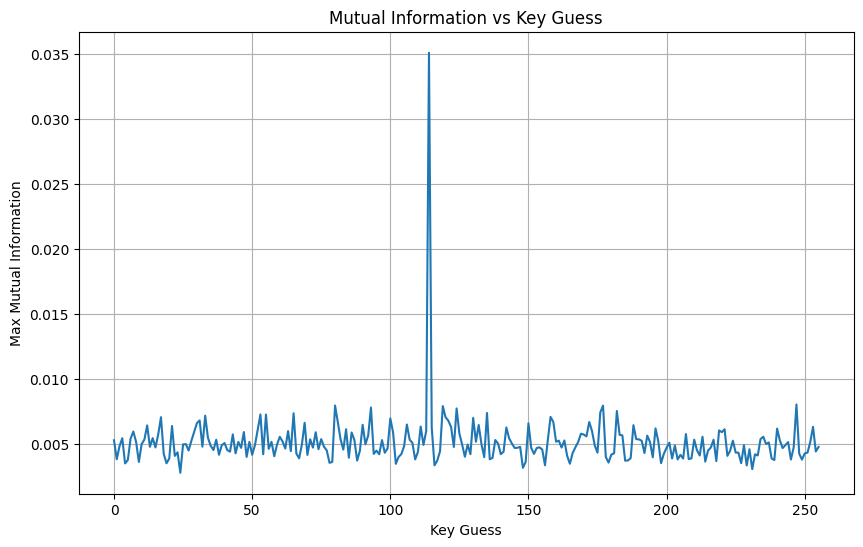

恢复的密钥字节（低噪声）：114


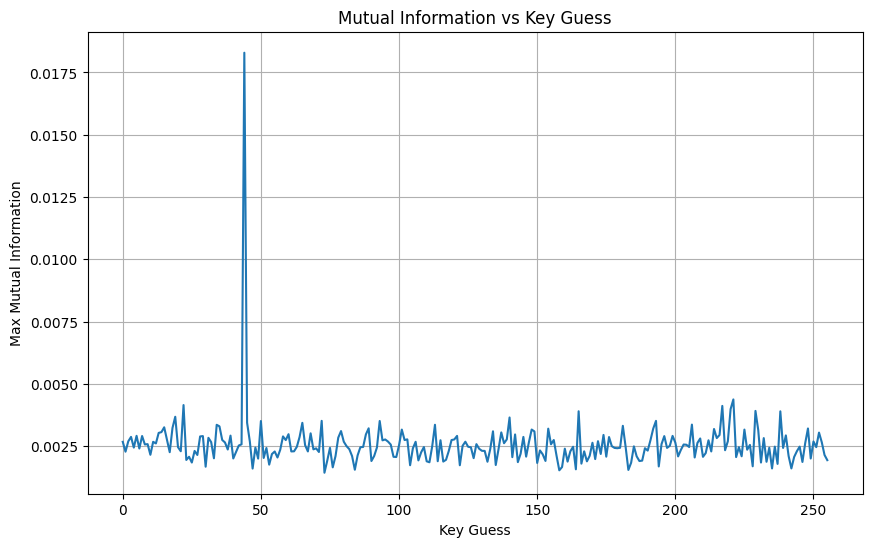

恢复的密钥字节（中噪声）：44


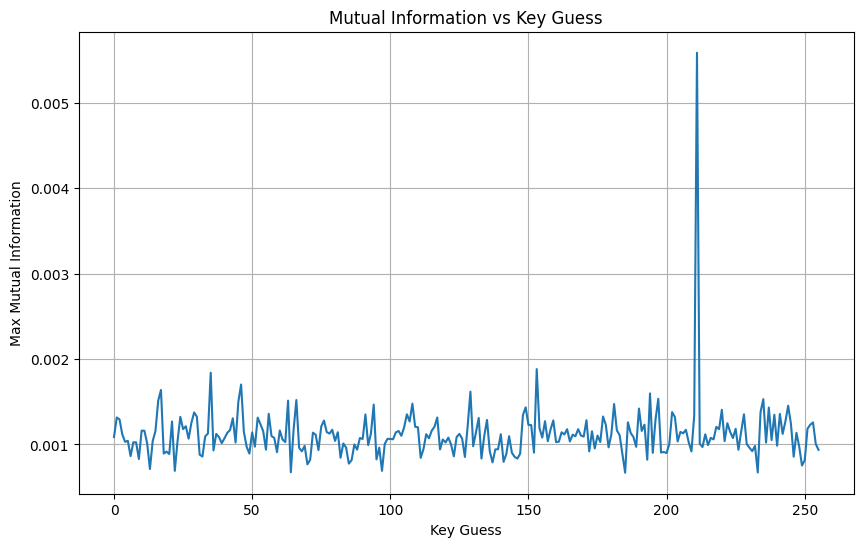

恢复的密钥字节（高噪声）：211


In [4]:
import numpy as np
from scipy.io import loadmat
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt

# 加载数据
plain_low = loadmat('plain_low.mat')['plain']
leakage_low = loadmat('leakage_low.mat')['leakage']
plain_medium = loadmat('plain_medium.mat')['plain']
leakage_medium = loadmat('leakage_medium.mat')['leakage']
plain_high = loadmat('plain_high.mat')['plain']
leakage_high = loadmat('leakage_high.mat')['leakage']

# 确保数据在0到255范围内
plain_low = plain_low % 256
plain_medium = plain_medium % 256
plain_high = plain_high % 256

# 确保数据形状正确
if plain_low.ndim == 1:
    plain_low = plain_low.reshape(-1, 1)
if plain_medium.ndim == 1:
    plain_medium = plain_medium.reshape(-1, 1)
if plain_high.ndim == 1:
    plain_high = plain_high.reshape(-1, 1)

# AES S盒
sbox = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]

# 汉明重量函数
def hamming_weight(n):
    return bin(n).count("1")

# 构建假设功耗函数
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 计算互信息
def calculate_mutual_information(leakage, hypothetical):
    num_samples = leakage.shape[1]  # 获取每条功耗曲线的采样点数量
    mutual_information = np.zeros(num_samples)  # 初始化互信息数组
    
    # 使用KBinsDiscretizer对泄露样本进行离散化处理
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    for i in range(num_samples):
        # 计算每个采样点的互信息
        mutual_information[i] = mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    return mutual_information

# 绘制互信息曲线函数
def plot_mutual_information(keys, mutual_informations, title):
    plt.figure(figsize=(10, 6))
    plt.plot(keys, mutual_informations)
    plt.title(title)
    plt.xlabel('Key Guess')
    plt.ylabel('Max Mutual Information')
    plt.grid(True)
    plt.show()

# 恢复密钥字节函数
def mia_attack(plain, leakage):
    num_guesses = 256
    max_mutual_information = np.zeros(num_guesses)
    
    for key_guess in range(num_guesses):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information(leakage, hypothetical)
        max_mutual_information[key_guess] = np.max(mutual_information)
    
    best_guess = np.argmax(max_mutual_information)
    keys = np.arange(num_guesses)
    plot_mutual_information(keys, max_mutual_information, 'Mutual Information vs Key Guess')
    return best_guess

# 执行MIA攻击（低噪声）
recovered_key_low = mia_attack(plain_low, leakage_low)
print(f'恢复的密钥字节（低噪声）：{recovered_key_low}')

# 执行MIA攻击（中噪声）
recovered_key_medium = mia_attack(plain_medium, leakage_medium)
print(f'恢复的密钥字节（中噪声）：{recovered_key_medium}')

# 执行MIA攻击（高噪声）
recovered_key_high = mia_attack(plain_high, leakage_high)
print(f'恢复的密钥字节（高噪声）：{recovered_key_high}')


# 计算以上代码运行时间

In [6]:
import numpy as np
import time
from scipy.io import loadmat
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# 加载数据
plain_low = loadmat('plain_low.mat')['plain']
leakage_low = loadmat('leakage_low.mat')['leakage']
plain_medium = loadmat('plain_medium.mat')['plain']
leakage_medium = loadmat('leakage_medium.mat')['leakage']
plain_high = loadmat('plain_high.mat')['plain']
leakage_high = loadmat('leakage_high.mat')['leakage']

# 确保数据在0到255范围内
plain_low = plain_low % 256
plain_medium = plain_medium % 256
plain_high = plain_high % 256

# 确保数据形状正确
if plain_low.ndim == 1:
    plain_low = plain_low.reshape(-1, 1)
if plain_medium.ndim == 1:
    plain_medium = plain_medium.reshape(-1, 1)
if plain_high.ndim == 1:
    plain_high = plain_high.reshape(-1, 1)

# AES S盒
sbox = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]

# 汉明重量函数
def hamming_weight(n):
    return bin(n).count("1")

# 构建假设功耗函数
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 计算互信息
def calculate_mutual_information(leakage, hypothetical):
    num_samples = leakage.shape[1]  # 获取每条功耗曲线的采样点数量
    mutual_information = np.zeros(num_samples)  # 初始化互信息数组
    
    # 使用KBinsDiscretizer对泄露样本进行离散化处理
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    for i in range(num_samples):
        # 计算每个采样点的互信息
        mutual_information[i] = mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    return mutual_information

# 恢复密钥字节函数
def mia_attack(plain, leakage):
    num_guesses = 256
    max_mutual_information = np.zeros(num_guesses)
    
    for key_guess in range(num_guesses):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information(leakage, hypothetical)
        max_mutual_information[key_guess] = np.max(mutual_information)
    
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复密钥
def run_attack_and_measure(plain, leakage, noise_level):
    start_time = time.time()
    recovered_key = mia_attack(plain, leakage)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'噪声水平：{noise_level}')
    print(f'恢复的密钥：{recovered_key}')
    print(f'运行时间：{elapsed_time:.4f}秒\n')

# 执行攻击并记录结果
run_attack_and_measure(plain_low, leakage_low, '低噪声')
run_attack_and_measure(plain_medium, leakage_medium, '中噪声')
run_attack_and_measure(plain_high, leakage_high, '高噪声')


噪声水平：低噪声
恢复的密钥：114
运行时间：5.9572秒

噪声水平：中噪声
恢复的密钥：44
运行时间：12.2051秒

噪声水平：高噪声
恢复的密钥：211
运行时间：24.6421秒



# 代码优化后

In [7]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# 加载数据
# 加载数据
plain_low = loadmat('plain_low.mat')['plain']
leakage_low = loadmat('leakage_low.mat')['leakage']
plain_medium = loadmat('plain_medium.mat')['plain']
leakage_medium = loadmat('leakage_medium.mat')['leakage']
plain_high = loadmat('plain_high.mat')['plain']
leakage_high = loadmat('leakage_high.mat')['leakage']

# 确保数据在0到255范围内
plain_low = plain_low % 256
plain_medium = plain_medium % 256
plain_high = plain_high % 256

# 确保数据形状正确
if plain_low.ndim == 1:
    plain_low = plain_low.reshape(-1, 1)
if plain_medium.ndim == 1:
    plain_medium = plain_medium.reshape(-1, 1)
if plain_high.ndim == 1:
    plain_high = plain_high.reshape(-1, 1)

# AES S盒
sbox = [
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
]

# 汉明重量函数
def hamming_weight(n):
    return bin(n).count("1")

# 构建假设功耗函数
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    mutual_information = np.zeros(num_samples)
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    max_mutual_information = np.zeros(num_guesses)
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    results = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    max_mutual_information = np.array(results)
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, true_key, noise_level, n_jobs=-1):
    start_time = time.time()
    best_guess = mia_attack_optimized(plain, leakage, n_jobs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'噪声水平：{noise_level}')
    print(f'恢复的密钥：{best_guess}')
    print(f'运行时间：{elapsed_time:.4f}秒\n')

# 预处理泄露数据
leakage_low = preprocess_leakage(leakage_low)
leakage_medium = preprocess_leakage(leakage_medium)
leakage_high = preprocess_leakage(leakage_high)

# 执行攻击并记录结果
run_attack_and_measure(plain_low, leakage_low, 0x72, '低噪声', n_jobs=-1)
run_attack_and_measure(plain_medium, leakage_medium, 0x2c, '中噪声', n_jobs=-1)
run_attack_and_measure(plain_high, leakage_high, 0xd3, '高噪声', n_jobs=-1)


噪声水平：低噪声
恢复的密钥：114
运行时间：2.7867秒

噪声水平：中噪声
恢复的密钥：44
运行时间：1.9780秒

噪声水平：高噪声
恢复的密钥：211
运行时间：3.6917秒



# 极致快

In [8]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level):
    start_time = time.time()
    recovered_key = mia_attack_optimized(plain, leakage)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f'Noise level: {noise_level} (Optimized)')
    print(f'Recovered key: {recovered_key}')
    print(f'Elapsed time: {elapsed_time:.4f} seconds\n')

# 加载并预处理数据
def load_and_preprocess_data():
    plain_low = loadmat('plain_low.mat')['plain']
    leakage_low = loadmat('leakage_low.mat')['leakage']
    plain_medium = loadmat('plain_medium.mat')['plain']
    leakage_medium = loadmat('leakage_medium.mat')['leakage']
    plain_high = loadmat('plain_high.mat')['plain']
    leakage_high = loadmat('leakage_high.mat')['leakage']

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare():
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data()
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]

    for (plain, leakage), noise_level in zip(data_sets, noise_levels):
        run_attack_and_measure(plain, leakage, noise_level)

execute_and_compare()


Noise level: Low Noise (Optimized)
Recovered key: 114
Elapsed time: 2.0760 seconds

Noise level: Medium Noise (Optimized)
Recovered key: 44
Elapsed time: 0.4804 seconds

Noise level: High Noise (Optimized)
Recovered key: 211
Elapsed time: 0.7473 seconds



# 添加手动设置攻击次数

Noise level: Low Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.5200 seconds
Recovered keys: [114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114]

Noise level: Medium Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.4316 seconds
Recovered keys: [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]

Noise level: High Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.5592 seconds
Recovered keys: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]

Noise Level: Low Noise
Success Rate: 100.00%
Average Time: 0.5200 seconds


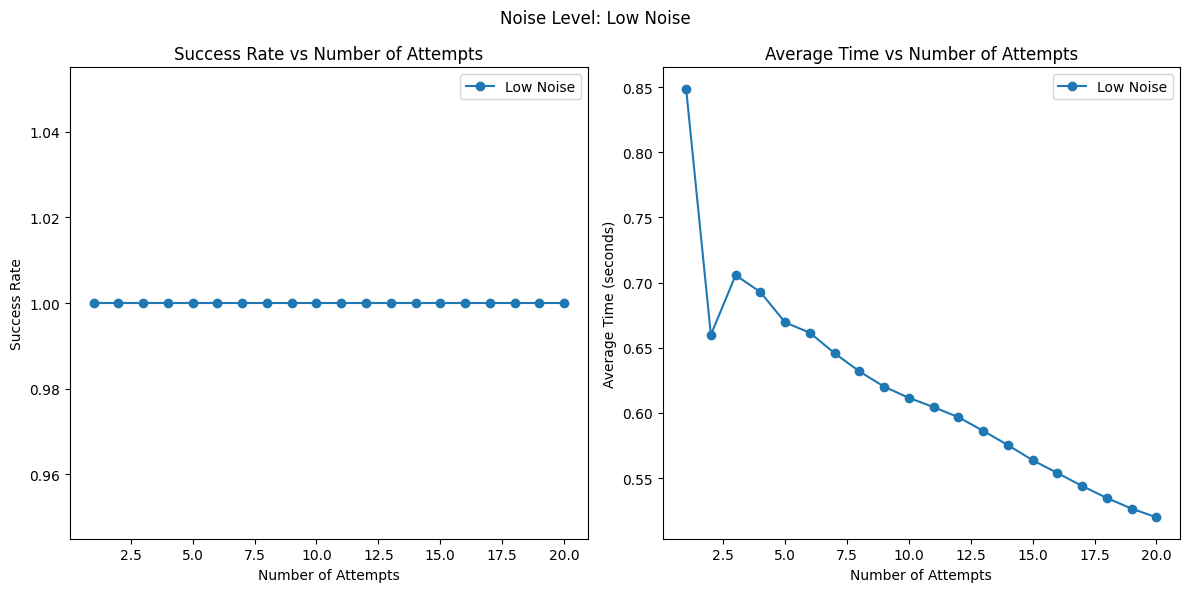

Noise Level: Medium Noise
Success Rate: 100.00%
Average Time: 0.4316 seconds


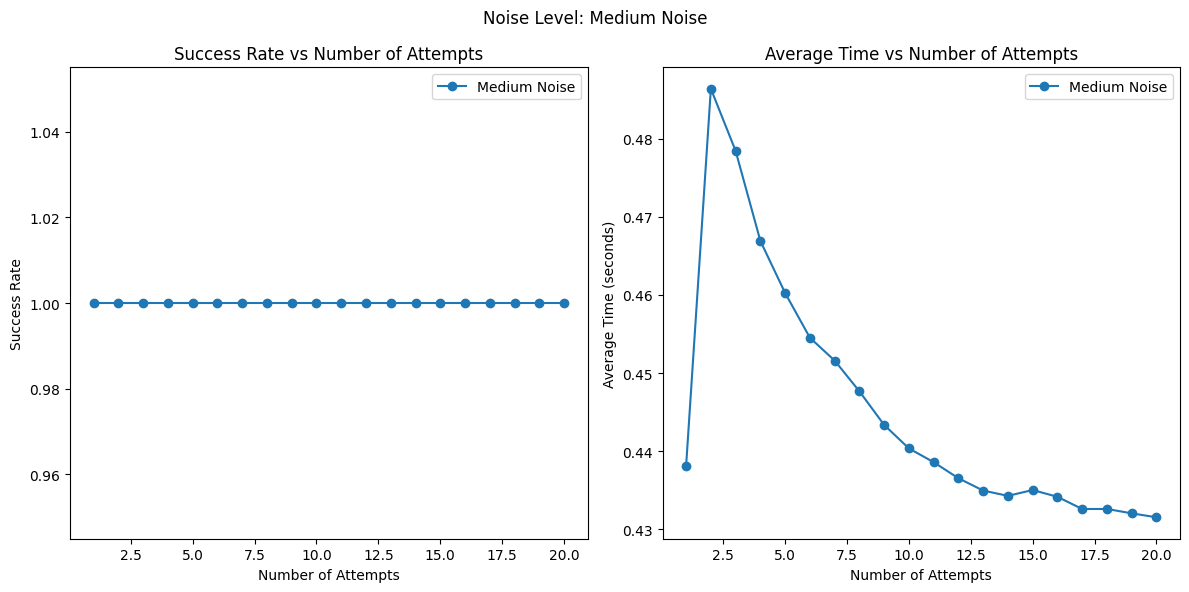

Noise Level: High Noise
Success Rate: 100.00%
Average Time: 0.5592 seconds


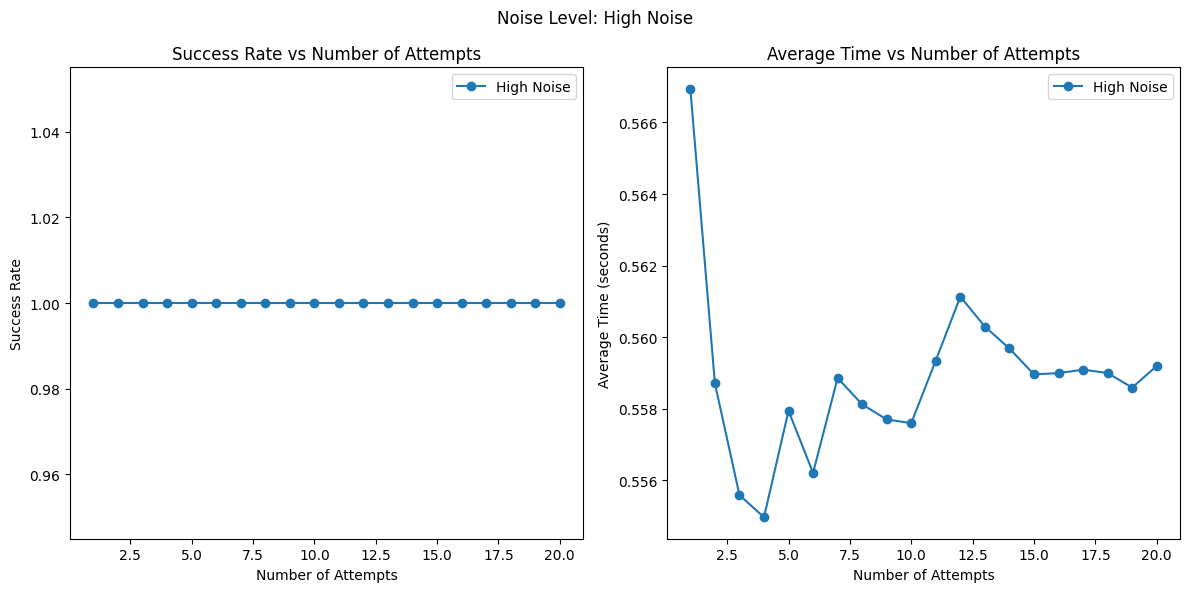

In [21]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    print(f'Noise level: {noise_level} (Optimized)')
    print(f'Success rate: {success_rate * 100:.2f}%')
    print(f'Average elapsed time: {average_time:.4f} seconds')
    print(f'Recovered keys: {recovered_keys}\n')

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data():
    plain_low = loadmat('plain_low.mat')['plain']
    leakage_low = loadmat('leakage_low.mat')['leakage']
    plain_medium = loadmat('plain_medium.mat')['plain']
    leakage_medium = loadmat('leakage_medium.mat')['leakage']
    plain_high = loadmat('plain_high.mat')['plain']
    leakage_high = loadmat('leakage_high.mat')['leakage']

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data()
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]

    results = []

    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        result = run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts)
        results.append(result)

    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        # 在绘图之前打印汇总信息
        print(f'Noise Level: {noise_level}')
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Time: {average_time:.4f} seconds')

        # 绘制成功率和平均运行时间的曲线
        attempts = range(1, num_attempts + 1)
        cumulative_success_rate = np.cumsum(success_counts) / attempts
        cumulative_average_time = np.cumsum(times) / attempts

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(attempts, cumulative_success_rate, marker='o', label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Success Rate')
        plt.title('Success Rate vs Number of Attempts')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(attempts, cumulative_average_time, marker='o', label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Average Time (seconds)')
        plt.title('Average Time vs Number of Attempts')
        plt.legend()

        plt.suptitle(f'Noise Level: {noise_level}')
        plt.tight_layout()
        plt.show()

# 手动设置攻击次数，例如设置为20次攻击
execute_and_compare(num_attempts=20)

# 代码优化

## 数据预处理和降噪：

使用Savitzky-Golay滤波器对泄露数据进行平滑处理，减少噪声。

## 高效的互信息计算：

使用KBinsDiscretizer对泄露数据进行离散化处理。
使用并行计算（joblib库中的Parallel和delayed）来加速互信息的计算。

## 并行计算：

mia_attack_optimized函数利用并行计算处理不同的密钥猜测，显著提高计算速度。

记录样本数和运行时间：

run_attack_and_measure函数记录每次攻击所用的样本数和总运行时间，并计算成功率。

Noise level: Low Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.4857 seconds
Recovered keys: [114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114]

Noise level: Medium Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.4623 seconds
Recovered keys: [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]

Noise level: High Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.6167 seconds
Recovered keys: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]

Noise Level: Low Noise
Success Rate: 100.00%
Average Time: 0.4857 seconds
Noise Level: Medium Noise
Success Rate: 100.00%
Average Time: 0.4623 seconds
Noise Level: High Noise
Success Rate: 100.00%
Average Time: 0.6167 seconds


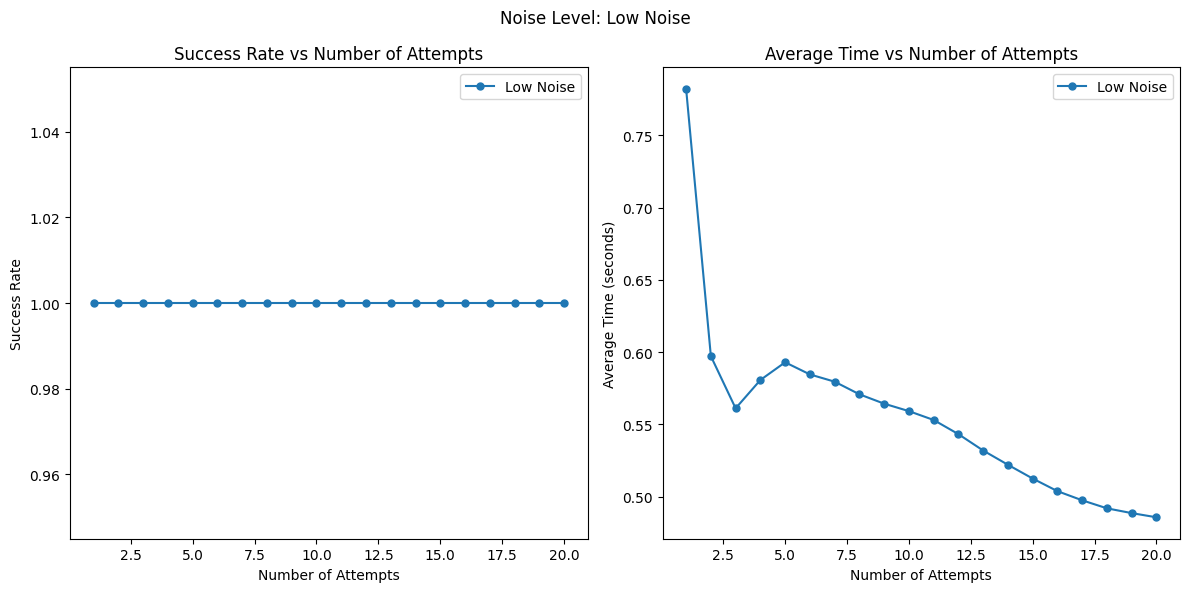

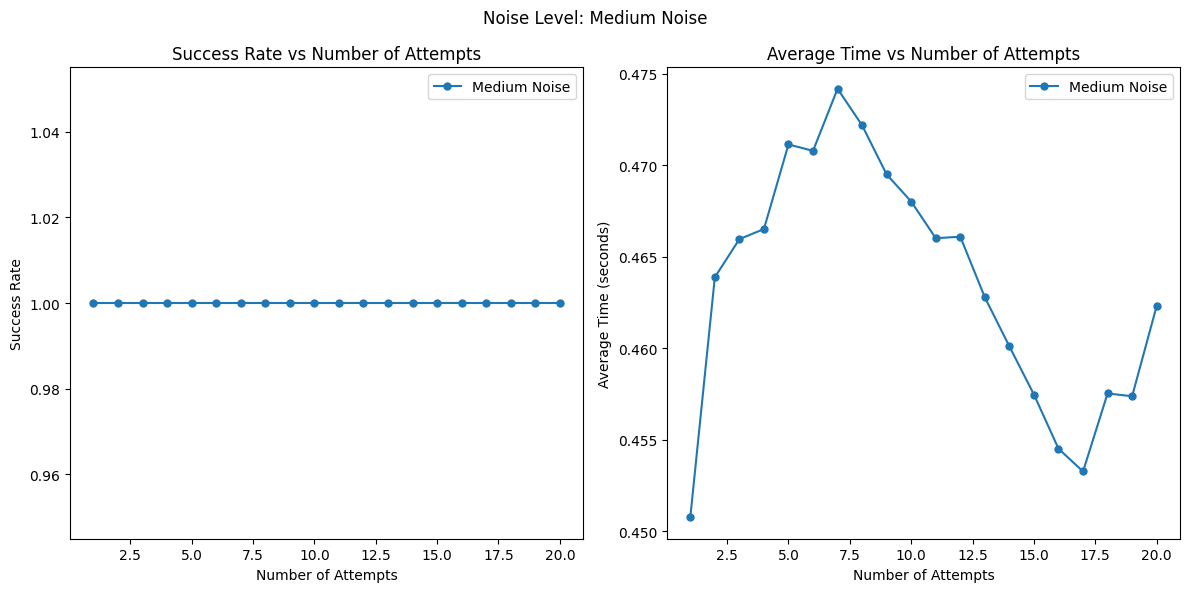

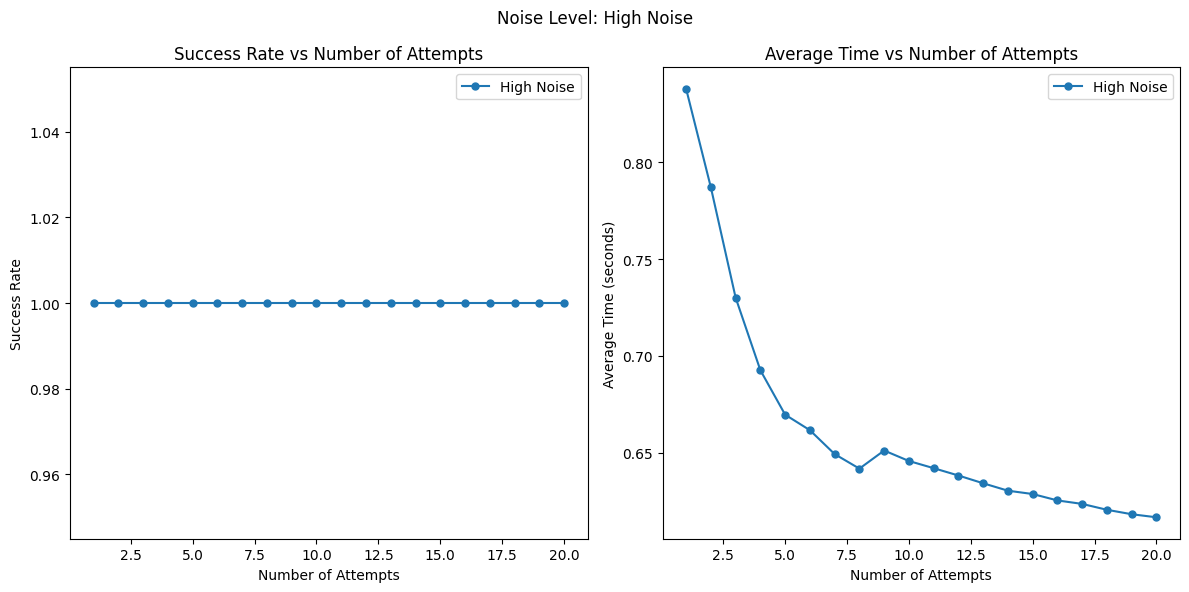

In [22]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    print(f'Noise level: {noise_level} (Optimized)')
    print(f'Success rate: {success_rate * 100:.2f}%')
    print(f'Average elapsed time: {average_time:.4f} seconds')
    print(f'Recovered keys: {recovered_keys}\n')

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data():
    plain_low = loadmat('plain_low.mat')['plain']
    leakage_low = loadmat('leakage_low.mat')['leakage']
    plain_medium = loadmat('plain_medium.mat')['plain']
    leakage_medium = loadmat('leakage_medium.mat')['leakage']
    plain_high = loadmat('plain_high.mat')['plain']
    leakage_high = loadmat('leakage_high.mat')['leakage']

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data()
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]

    results = []

    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        result = run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts)
        results.append(result)

    # 在所有结果计算完成后，统一打印汇总信息
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        # 打印每个噪声级别的成功率和平均时间
        print(f'Noise Level: {noise_level}')
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Time: {average_time:.4f} seconds')

    # 统一绘制成功率和平均运行时间的曲线
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        attempts = range(1, num_attempts + 1)
        cumulative_success_rate = np.cumsum(success_counts) / attempts
        cumulative_average_time = np.cumsum(times) / attempts

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(attempts, cumulative_success_rate, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Success Rate')
        plt.title('Success Rate vs Number of Attempts')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(attempts, cumulative_average_time, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Average Time (seconds)')
        plt.title('Average Time vs Number of Attempts')
        plt.legend()

        plt.suptitle(f'Noise Level: {noise_level}')
        plt.tight_layout()
        plt.show()

# 手动设置攻击次数，例如设置为20次攻击
execute_and_compare(num_attempts=20)


Noise Level: Low Noise
Success Rate: 100.00%
Average Time: 0.5267 seconds
Noise Level: Medium Noise
Success Rate: 100.00%
Average Time: 0.4918 seconds
Noise Level: High Noise
Success Rate: 100.00%
Average Time: 0.6153 seconds


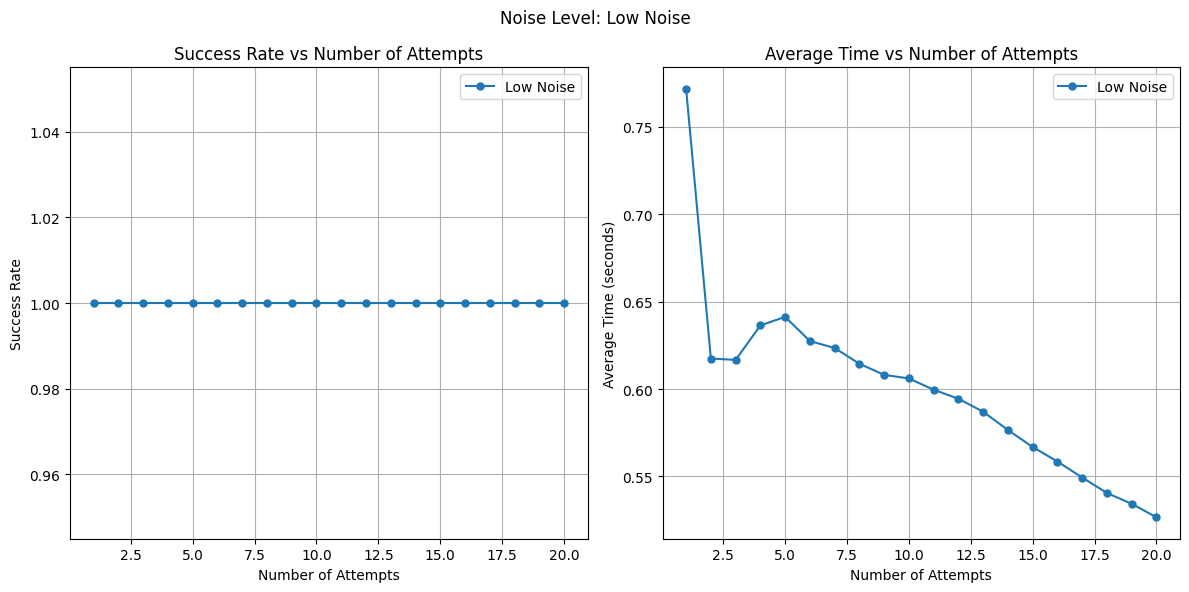

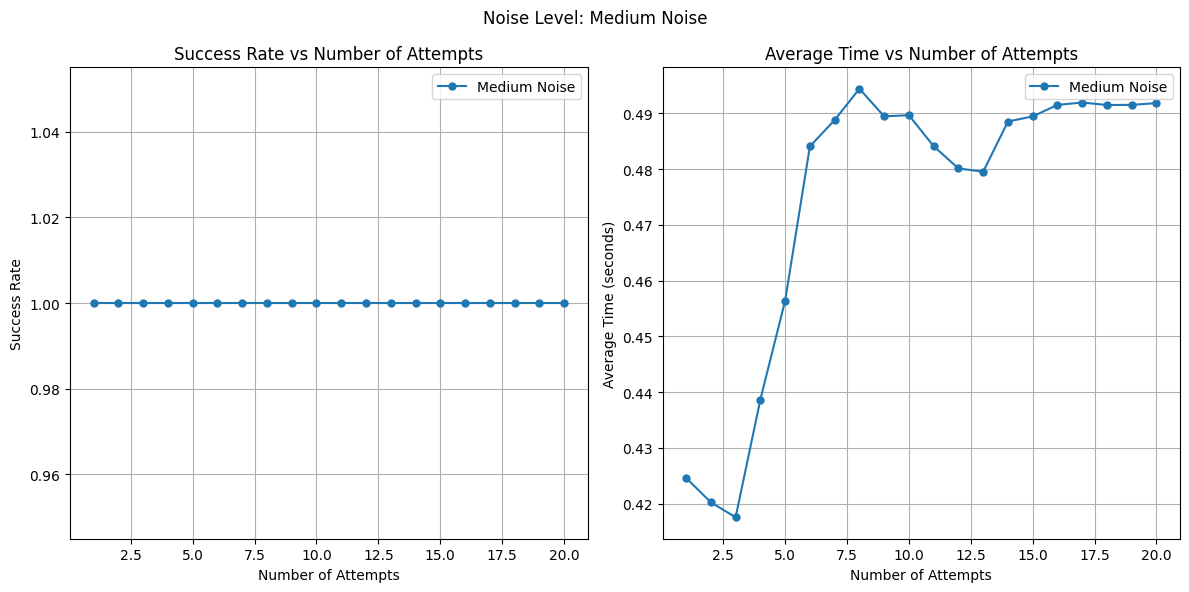

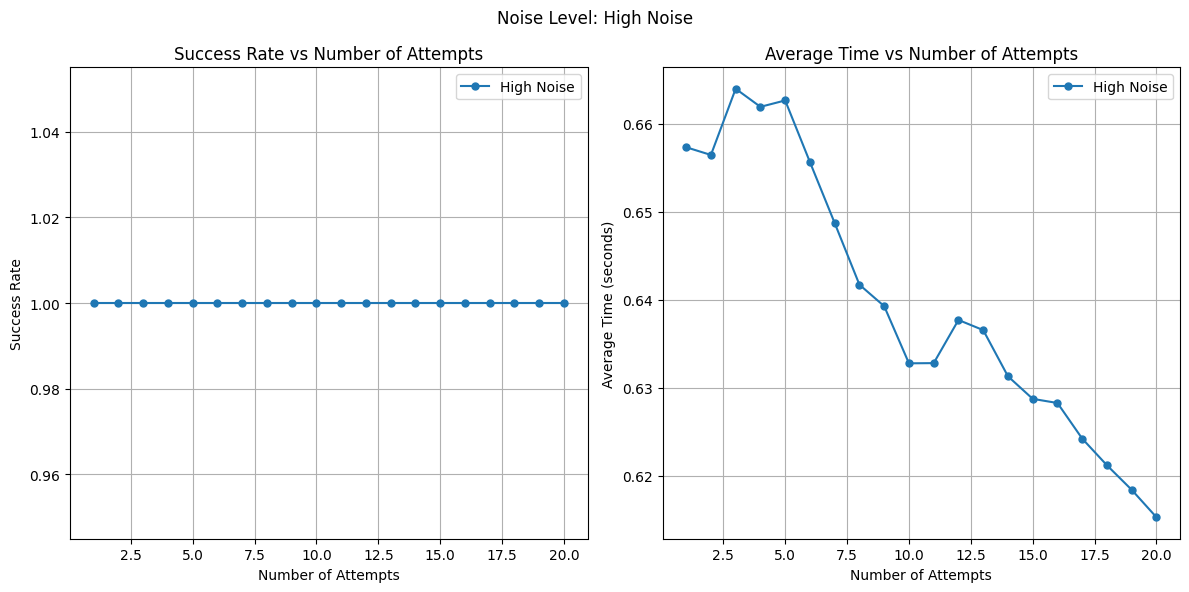

In [23]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data():
    plain_low = loadmat('plain_low.mat')['plain']
    leakage_low = loadmat('leakage_low.mat')['leakage']
    plain_medium = loadmat('plain_medium.mat')['plain']
    leakage_medium = loadmat('leakage_medium.mat')['leakage']
    plain_high = loadmat('plain_high.mat')['plain']
    leakage_high = loadmat('leakage_high.mat')['leakage']

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data()
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]

    results = []

    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        result = run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts)
        results.append(result)

    # 在所有结果计算完成后，统一打印汇总信息
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        # 打印每个噪声级别的成功率和平均时间
        print(f'Noise Level: {noise_level}')
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Time: {average_time:.4f} seconds')

    # 统一绘制成功率和平均运行时间的曲线
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        attempts = range(1, num_attempts + 1)
        cumulative_success_rate = np.cumsum(success_counts) / attempts
        cumulative_average_time = np.cumsum(times) / attempts

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(attempts, cumulative_success_rate, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Success Rate')
        plt.title('Success Rate vs Number of Attempts')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(attempts, cumulative_average_time, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Average Time (seconds)')
        plt.title('Average Time vs Number of Attempts')
        plt.legend()
        plt.grid(True)

        plt.suptitle(f'Noise Level: {noise_level}')
        plt.tight_layout()
        plt.show()

# 手动设置攻击次数，例如设置为20次攻击
execute_and_compare(num_attempts=20)


# 互信息终极优化版

数据源是官方数据源的情况下，该版本增加了手动设置低中高噪数据条数和攻击次数功能，这段代码运行次数和样本量相同的情况下速度最快！

Noise Level: Low Noise

Success Rate: 100.00%

Average Time: 0.4778 seconds

Noise Level: Medium Noise

Success Rate: 100.00%

Average Time: 0.3381 seconds

Noise Level: High Noise

Success Rate: 100.00%

Average Time: 0.3437 seconds

Noise Level: Low Noise
Success Rate: 100.00%
Average Time: 0.4778 seconds
Noise Level: Medium Noise
Success Rate: 100.00%
Average Time: 0.3381 seconds
Noise Level: High Noise
Success Rate: 100.00%
Average Time: 0.3437 seconds


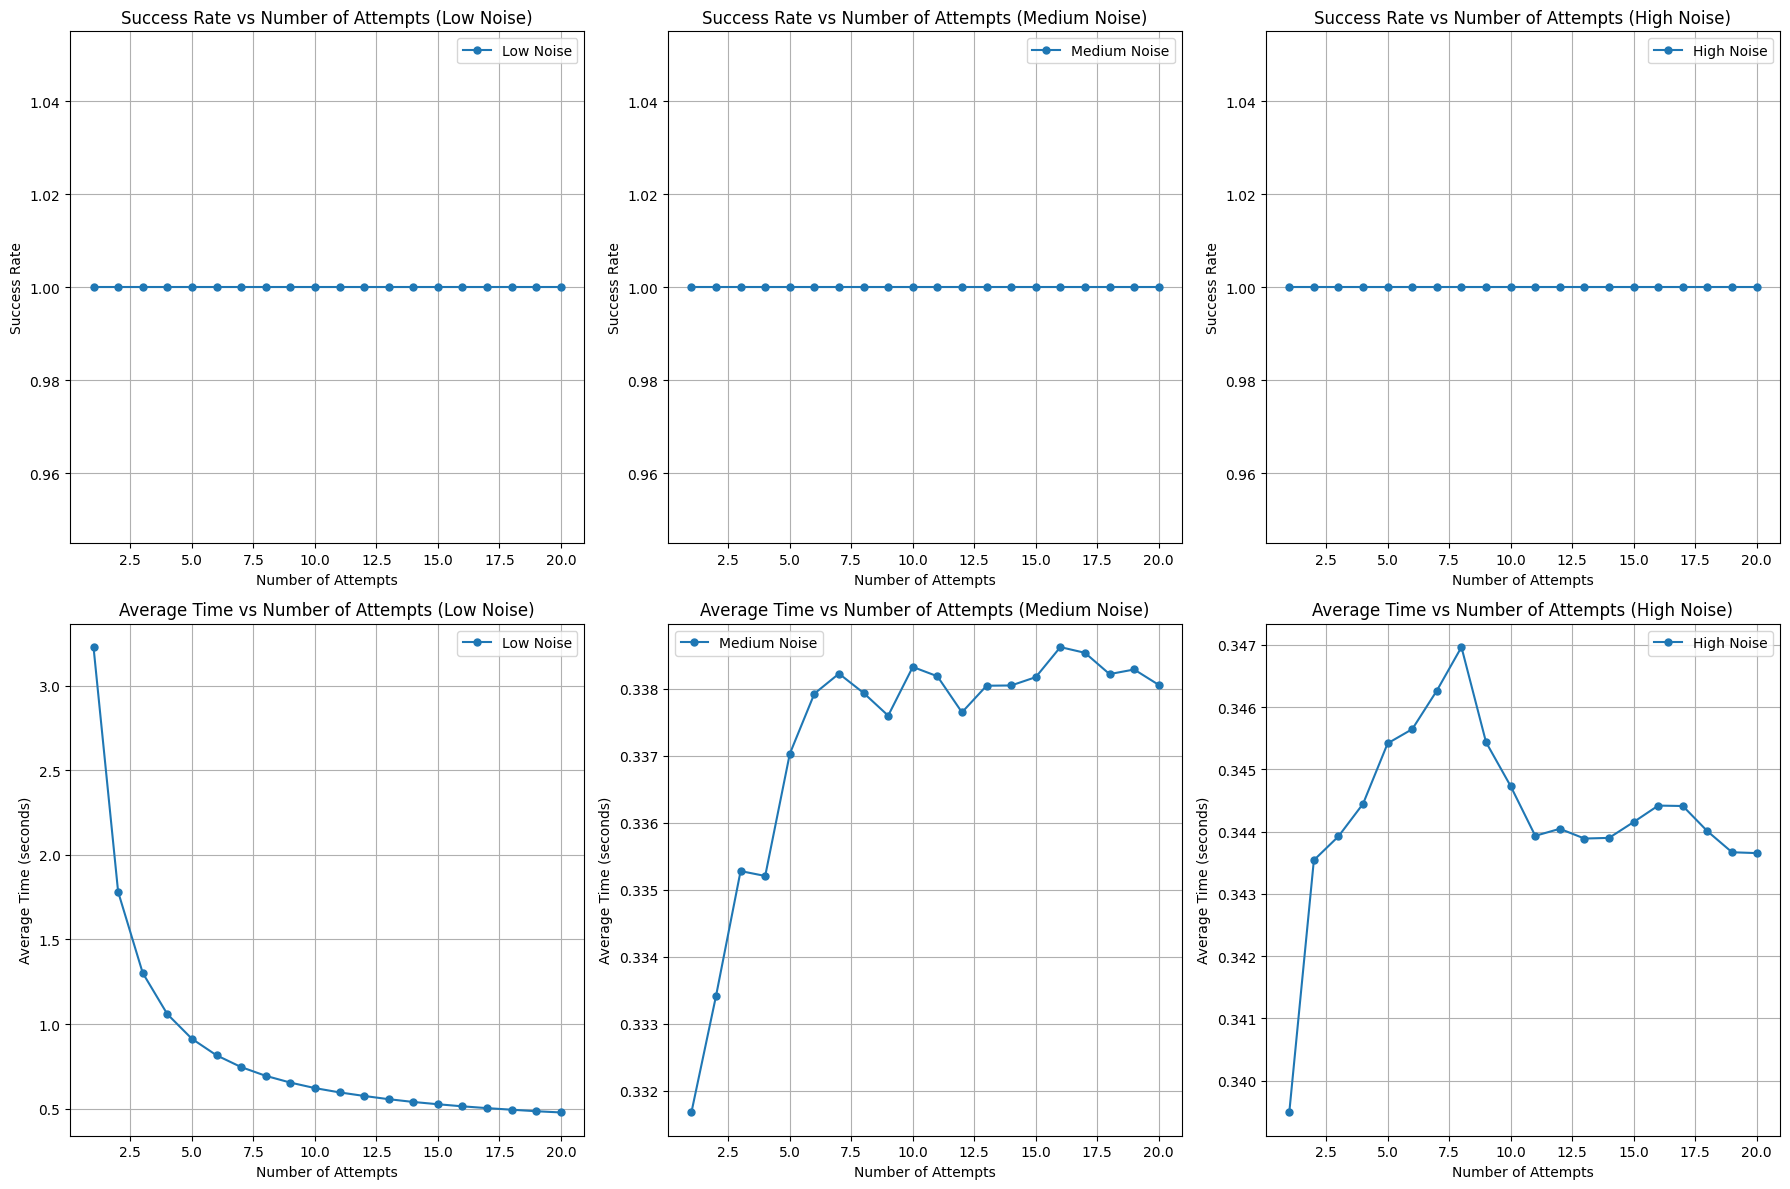

In [3]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data(low_count, medium_count, high_count):
    plain_low = loadmat('plain_low.mat')['plain'][:low_count]
    leakage_low = loadmat('leakage_low.mat')['leakage'][:low_count]
    plain_medium = loadmat('plain_medium.mat')['plain'][:medium_count]
    leakage_medium = loadmat('leakage_medium.mat')['leakage'][:medium_count]
    plain_high = loadmat('plain_high.mat')['plain'][:high_count]
    leakage_high = loadmat('leakage_high.mat')['leakage'][:high_count]

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10, low_count=1000, medium_count=1000, high_count=1000):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data(low_count, medium_count, high_count)
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]

    results = []

    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        result = run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts)
        results.append(result)

    # 在所有结果计算完成后，统一打印汇总信息
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        # 打印每个噪声级别的成功率和平均时间
        print(f'Noise Level: {noise_level}')
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Time: {average_time:.4f} seconds')

    # 统一绘制成功率和平均运行时间的曲线
    plt.figure(figsize=(18, 12))
    
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        attempts = range(1, num_attempts + 1)
        cumulative_success_rate = np.cumsum(success_counts) / attempts
        cumulative_average_time = np.cumsum(times) / attempts

        # 成功率曲线
        plt.subplot(2, 3, noise_levels.index(noise_level) + 1)
        plt.plot(attempts, cumulative_success_rate, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Success Rate')
        plt.title(f'Success Rate vs Number of Attempts ({noise_level})')
        plt.legend()
        plt.grid(True)

        # 平均时间曲线
        plt.subplot(2, 3, noise_levels.index(noise_level) + 4)
        plt.plot(attempts, cumulative_average_time, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Average Time (seconds)')
        plt.title(f'Average Time vs Number of Attempts ({noise_level})')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 手动设置攻击次数和不同噪声级别的数据条数
execute_and_compare(num_attempts=20, low_count=1000, medium_count=2000, high_count=4000)

# 快的基础上删除以上代码画图环节

Noise Level: Low Noise

Success Rate: 100.00%

Average Time: 0.4555 seconds

Noise Level: Medium Noise

Success Rate: 100.00%

Average Time: 0.3478 seconds

Noise Level: High Noise

Success Rate: 100.00%

Average Time: 0.3469 seconds

In [4]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data(low_count, medium_count, high_count):
    plain_low = loadmat('plain_low.mat')['plain'][:low_count]
    leakage_low = loadmat('leakage_low.mat')['leakage'][:low_count]
    plain_medium = loadmat('plain_medium.mat')['plain'][:medium_count]
    leakage_medium = loadmat('leakage_medium.mat')['leakage'][:medium_count]
    plain_high = loadmat('plain_high.mat')['plain'][:high_count]
    leakage_high = loadmat('leakage_high.mat')['leakage'][:high_count]

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10, low_count=1000, medium_count=1000, high_count=1000):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data(low_count, medium_count, high_count)
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]

    results = []

    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        result = run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts)
        results.append(result)

    # 在所有结果计算完成后，统一打印汇总信息
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        # 打印每个噪声级别的成功率和平均时间
        print(f'Noise Level: {noise_level}')
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Time: {average_time:.4f} seconds')
# 手动设置攻击次数和不同噪声级别的数据条数
execute_and_compare(num_attempts=20, low_count=1000, medium_count=2000, high_count=4000)

Noise Level: Low Noise
Success Rate: 100.00%
Average Time: 0.4555 seconds
Noise Level: Medium Noise
Success Rate: 100.00%
Average Time: 0.3478 seconds
Noise Level: High Noise
Success Rate: 100.00%
Average Time: 0.3469 seconds


# 对比

Noise Level: Low Noise

Success Rate: 100.00%

Average Time: 0.6077 seconds

Noise Level: Medium Noise

Success Rate: 100.00%

Average Time: 0.3572 seconds

Noise Level: High Noise

Success Rate: 100.00%

Average Time: 0.3720 seconds

Noise level: Low Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.6077 seconds
Recovered keys: [114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114]

Noise level: Medium Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.3572 seconds
Recovered keys: [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44]

Noise level: High Noise (Optimized)
Success rate: 100.00%
Average elapsed time: 0.3720 seconds
Recovered keys: [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]

Noise Level: Low Noise
Success Rate: 100.00%
Average Time: 0.6077 seconds
Noise Level: Medium Noise
Success Rate: 100.00%
Average Time: 0.3572 seconds
Noise Level: High Noise
Success Rate: 100.00%
Average Time: 0.3720 seconds


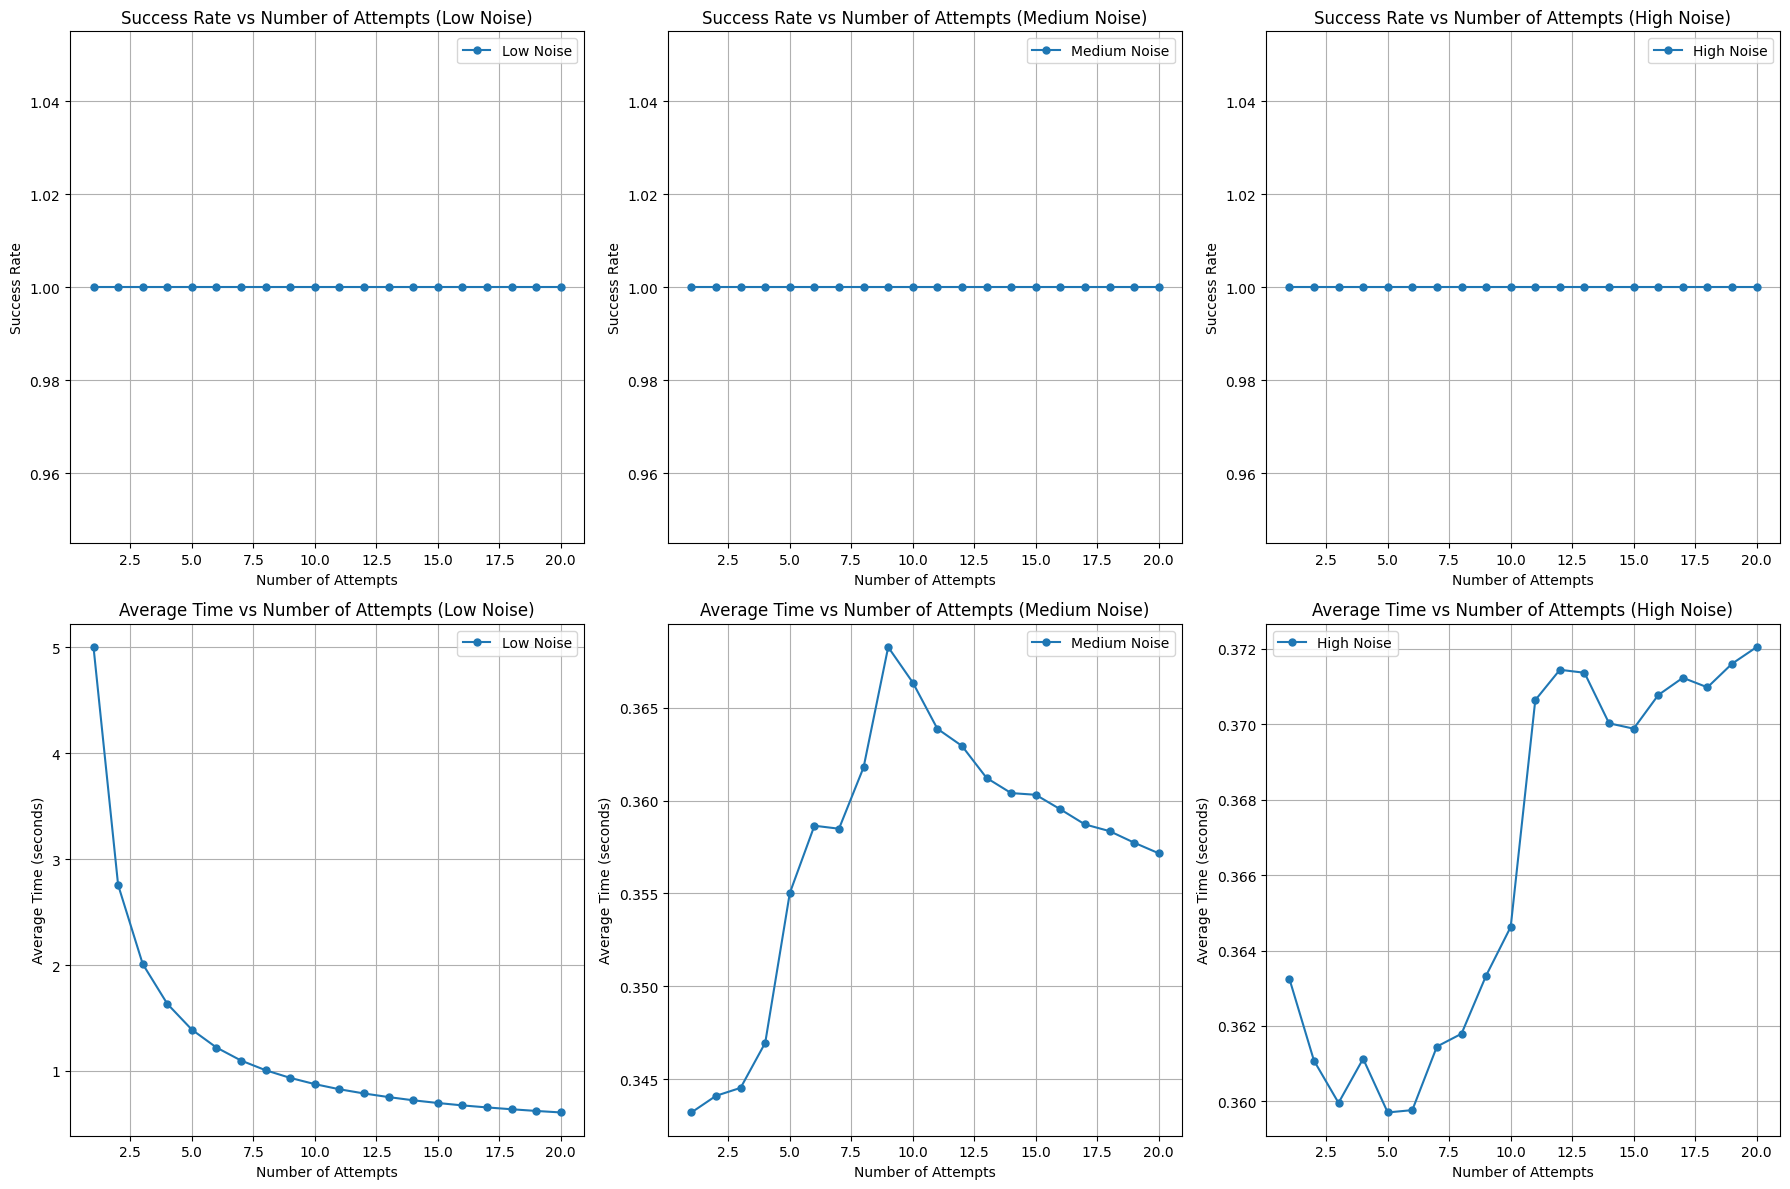

In [7]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪
def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=None)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    print(f'Noise level: {noise_level} (Optimized)')
    print(f'Success rate: {success_rate * 100:.2f}%')
    print(f'Average elapsed time: {average_time:.4f} seconds')
    print(f'Recovered keys: {recovered_keys}\n')

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data(low_count, medium_count, high_count):
    plain_low = loadmat('plain_low.mat')['plain'][:low_count]
    leakage_low = loadmat('leakage_low.mat')['leakage'][:low_count]
    plain_medium = loadmat('plain_medium.mat')['plain'][:medium_count]
    leakage_medium = loadmat('leakage_medium.mat')['leakage'][:medium_count]
    plain_high = loadmat('plain_high.mat')['plain'][:high_count]
    leakage_high = loadmat('leakage_high.mat')['leakage'][:high_count]

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10, low_count=1000, medium_count=1000, high_count=1000):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data(low_count, medium_count, high_count)
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]
    results = []

    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        result = run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts)
        results.append(result)

    # 打印每个噪声级别的成功率和平均时间
    for noise_level, success_rate, average_time in zip(noise_levels, [x[3] for x in results], [x[4] for x in results]):
        print(f'Noise Level: {noise_level}')
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Time: {average_time:.4f} seconds')

    # 统一绘制成功率和平均运行时间的曲线
    plt.figure(figsize=(18, 12))

    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        attempts = range(1, num_attempts + 1)
        cumulative_success_rate = np.cumsum(success_counts) / attempts
        cumulative_average_time = np.cumsum(times) / attempts

        # 成功率曲线
        plt.subplot(2, 3, noise_levels.index(noise_level) + 1)
        plt.plot(attempts, cumulative_success_rate, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Success Rate')
        plt.title(f'Success Rate vs Number of Attempts ({noise_level})')
        plt.legend()
        plt.grid(True)

        # 平均时间曲线
        plt.subplot(2, 3, noise_levels.index(noise_level) + 4)
        plt.plot(attempts, cumulative_average_time, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Average Time (seconds)')
        plt.title(f'Average Time vs Number of Attempts ({noise_level})')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 手动设置攻击次数和不同噪声级别的数据条数
execute_and_compare(num_attempts=20, low_count=1000, medium_count=2000, high_count=4000)

# 数据降噪及效果对比
针对数据降噪，可以采用以下几种常见的方法：

1. Savitzky-Golay滤波器
Savitzky-Golay滤波器是一种用于平滑数据的数字滤波器，它通过多项式拟合数据点来平滑数据。适用于平滑带噪声的信号，同时保持信号的趋势和特性。

```
from scipy.signal import savgol_filter

def preprocess_leakage(leakage):
    window_length = min(11, leakage.shape[1])  # 动态调整window_length，确保不会超过数据大小
    polyorder = min(2, window_length - 1)  # 确保polyorder小于window_length
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage
```
2. 移动平均滤波器
移动平均滤波器通过计算一段时间窗口内的数据平均值来平滑数据，适用于减少随机噪声，但会导致信号边缘的失真。

```
def moving_average_filter(leakage, window_size=5):
    return np.convolve(leakage, np.ones(window_size)/window_size, mode='valid')
```
3. 小波去噪
小波去噪通过将信号分解为不同频率分量，然后去除噪声较高的分量来平滑数据，适用于处理非平稳信号。

```
import pywt

def wavelet_denoising(leakage, wavelet='db1', level=1):
    coeffs = pywt.wavedec(leakage, wavelet, mode='symmetric')
    threshold = np.sqrt(2*np.log(len(leakage)))
    denoised_coeffs = map(lambda x: pywt.threshold(x, threshold, mode='soft'), coeffs)
    return pywt.waverec(list(denoised_coeffs), wavelet, mode='symmetric')
```
4. 卡尔曼滤波器
卡尔曼滤波器是一种基于状态空间模型的递归滤波器，适用于动态系统的实时去噪和状态估计。

```
import pykalman

def kalman_filter(leakage):
    kf = pykalman.KalmanFilter(initial_state_mean=leakage[0], n_dim_obs=1)
    smoothed_state_means, _ = kf.smooth(leakage)
    return smoothed_state_means
```
5. 中值滤波器
中值滤波器通过取局部窗口内的中值来平滑数据，适用于去除脉冲噪声。
```
from scipy.signal import medfilt

def median_filter(leakage, kernel_size=3):
    return medfilt(leakage, kernel_size=kernel_size)
```

# 结果对比
综合来看，同等攻击次数相同样本数量时，使用Moving Average降噪方法时，低中高噪用时最少，后续代码在最快的前提下将不使用Savitzky-Golay滤波器使用Moving Average滤波器，代码运行后结果将会附在下面，以供选择。

In [2]:
import numpy as np
import time
from scipy.io import loadmat
from scipy.signal import savgol_filter, medfilt
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt
import pywt
import pykalman

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# Savitzky-Golay滤波器降噪
def preprocess_leakage_savgol(leakage):
    window_length = min(11, leakage.shape[1])
    polyorder = min(2, window_length - 1)
    smoothed_leakage = savgol_filter(leakage, window_length=window_length, polyorder=polyorder, axis=1)
    return smoothed_leakage

# 移动平均滤波器降噪
def moving_average_filter(leakage, window_size=5):
    window_size = min(window_size, leakage.shape[1])
    return np.array([np.convolve(trace, np.ones(window_size)/window_size, mode='valid') for trace in leakage])

# 小波去噪
def wavelet_denoising(leakage, wavelet='db1', level=1):
    denoised_leakage = []
    for trace in leakage:
        coeffs = pywt.wavedec(trace, wavelet, mode='symmetric')
        threshold = np.sqrt(2*np.log(len(trace)))
        denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
        denoised_trace = pywt.waverec(denoised_coeffs, wavelet, mode='symmetric')
        denoised_leakage.append(denoised_trace[:len(trace)])  # Ensure the same length as original
    return np.array(denoised_leakage)

# 卡尔曼滤波器降噪
def kalman_filter(leakage):
    kf = pykalman.KalmanFilter(initial_state_mean=leakage[:,0], n_dim_obs=1)
    smoothed_state_means = np.array([kf.smooth(trace)[0].flatten() for trace in leakage])
    return smoothed_state_means

# 中值滤波器降噪
def median_filter(leakage, kernel_size=3):
    kernel_size = min(kernel_size, leakage.shape[1])
    return np.array([medfilt(trace, kernel_size=kernel_size) for trace in leakage])

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data(low_count, medium_count, high_count):
    plain_low = loadmat('plain_low.mat')['plain'][:low_count]
    leakage_low = loadmat('leakage_low.mat')['leakage'][:low_count]
    plain_medium = loadmat('plain_medium.mat')['plain'][:medium_count]
    leakage_medium = loadmat('leakage_medium.mat')['leakage'][:medium_count]
    plain_high = loadmat('plain_high.mat')['plain'][:high_count]
    leakage_high = loadmat('leakage_high.mat')['leakage'][:high_count]

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 应用不同的降噪方法
def apply_denoising_methods(leakage_data):
    methods = {
        'Savitzky-Golay': preprocess_leakage_savgol,
        'Moving Average': moving_average_filter,
        'Wavelet Denoising': wavelet_denoising,
        'Kalman Filter': kalman_filter,
        'Median Filter': median_filter
    }
    
    denoised_data = {method: func(leakage_data.copy()) for method, func in methods.items()}
    return denoised_data

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10, low_count=1000, medium_count=1000, high_count=1000):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data(low_count, medium_count, high_count)
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]
    
    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        denoised_data = apply_denoising_methods(leakage)
        
        for method, denoised_leakage in denoised_data.items():
            # 去除常量特征
            selector = VarianceThreshold()
            denoised_leakage = selector.fit_transform(denoised_leakage)
            
            result = run_attack_and_measure(plain, denoised_leakage, noise_level, true_key, num_attempts)
            success_counts, times, recovered_keys, success_rate, average_time = result

            print(f'Noise Level: {noise_level}, Denoising Method: {method}')
            print(f'Success Rate: {success_rate * 100:.2f}%')
            print(f'Average Time: {average_time:.4f} seconds')

# 手动设置攻击次数和不同噪声级别的数据条数
execute_and_compare(num_attempts=10, low_count=1000, medium_count=2000, high_count=4000)

Noise Level: Low Noise, Denoising Method: Savitzky-Golay
Success Rate: 100.00%
Average Time: 0.6850 seconds
Noise Level: Low Noise, Denoising Method: Moving Average
Success Rate: 100.00%
Average Time: 0.3794 seconds
Noise Level: Low Noise, Denoising Method: Wavelet Denoising
Success Rate: 100.00%
Average Time: 0.4003 seconds
Noise Level: Low Noise, Denoising Method: Kalman Filter
Success Rate: 100.00%
Average Time: 0.4030 seconds
Noise Level: Low Noise, Denoising Method: Median Filter
Success Rate: 100.00%
Average Time: 0.4039 seconds
Noise Level: Medium Noise, Denoising Method: Savitzky-Golay
Success Rate: 100.00%
Average Time: 0.3986 seconds
Noise Level: Medium Noise, Denoising Method: Moving Average
Success Rate: 100.00%
Average Time: 0.4024 seconds
Noise Level: Medium Noise, Denoising Method: Wavelet Denoising
Success Rate: 100.00%
Average Time: 0.4014 seconds
Noise Level: Medium Noise, Denoising Method: Kalman Filter
Success Rate: 100.00%
Average Time: 0.4003 seconds
Noise Level: 

# 使用Moving Average滤波器完成以上任务

Noise Level: Low Noise
Success Rate: 100.00%
Average Time: 0.4001 seconds
Noise Level: Medium Noise
Success Rate: 100.00%
Average Time: 0.3542 seconds
Noise Level: High Noise
Success Rate: 100.00%
Average Time: 0.3551 seconds


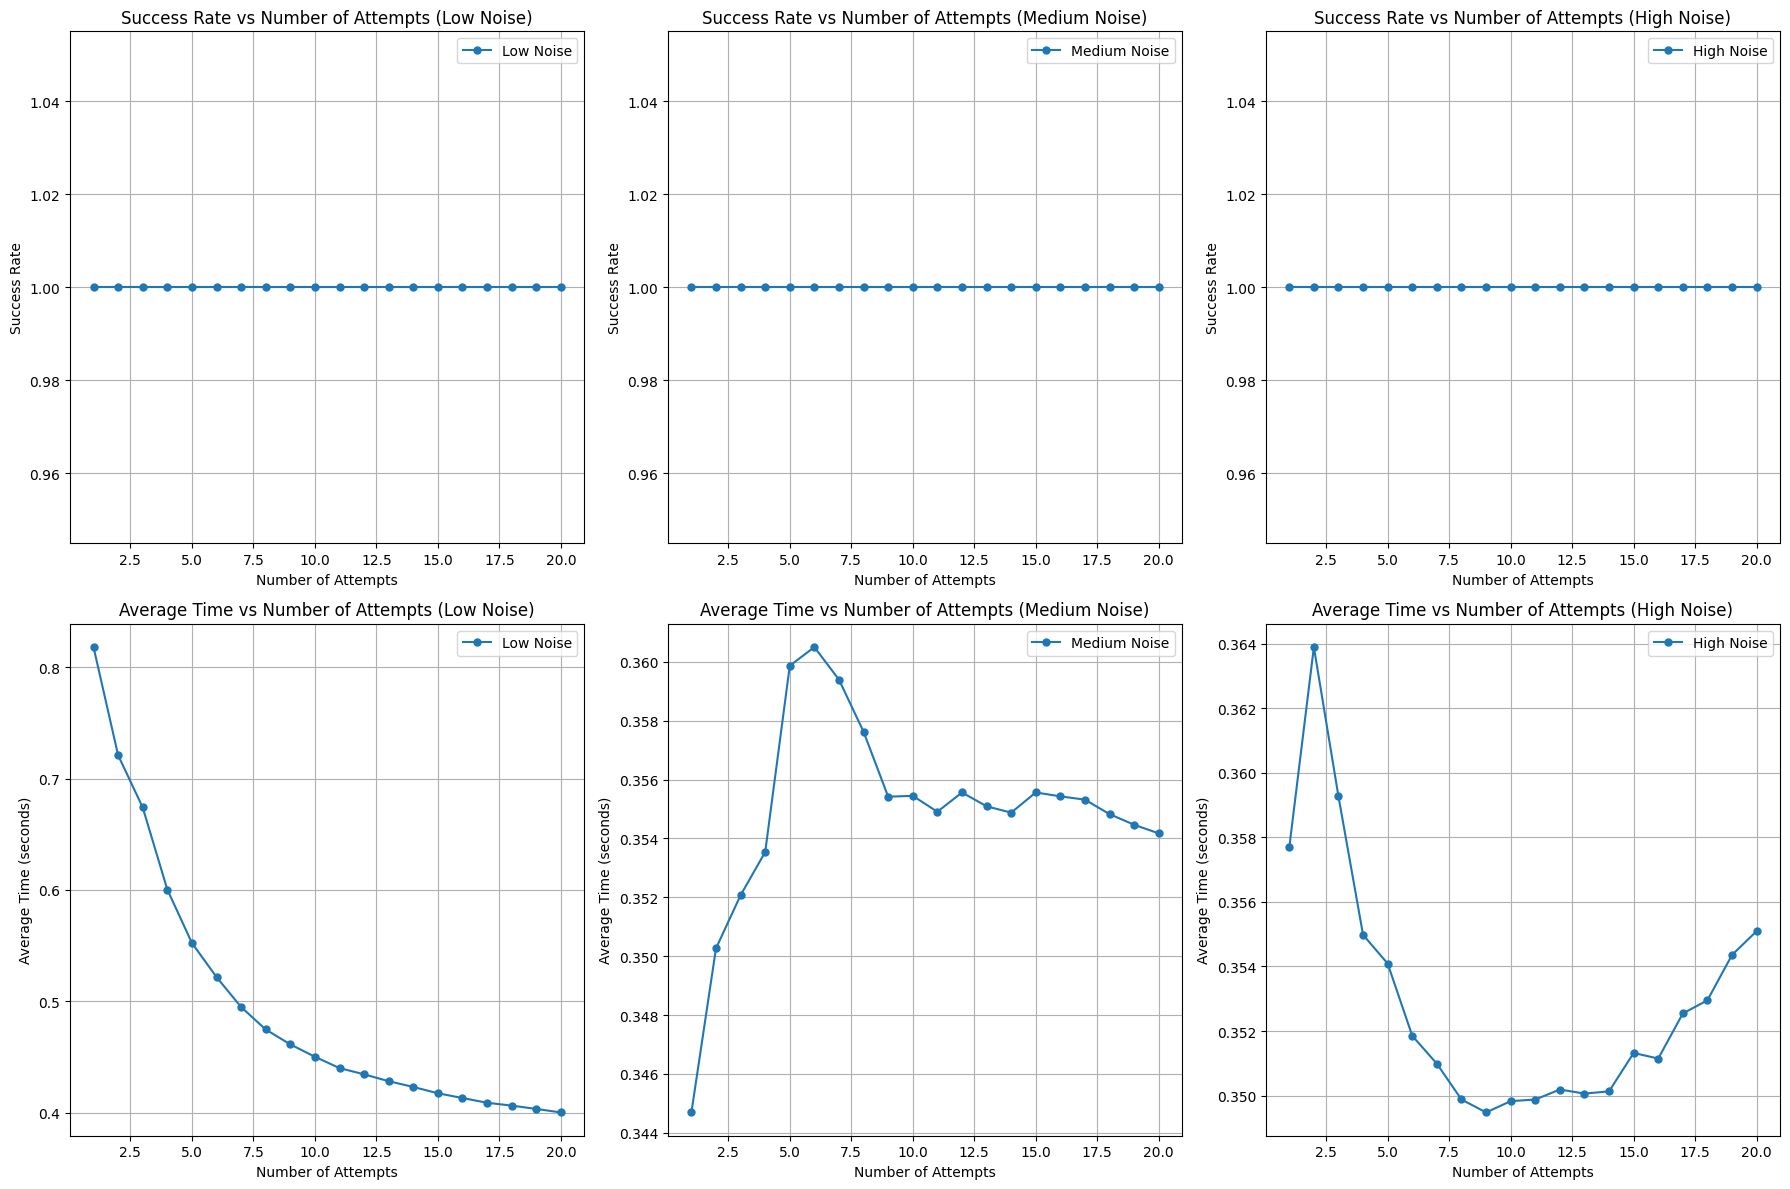

In [18]:
import numpy as np
import time
from scipy.io import loadmat
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from numba import njit
import matplotlib.pyplot as plt

# AES S盒
sbox = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

# 汉明重量函数（使用Numba加速）
@njit
def hamming_weight(n):
    weight = 0
    while n:
        weight += n & 1
        n >>= 1
    return weight

# 构建假设功耗函数（使用Numba加速）
@njit
def hypothetical_leakage(plain, key_guess):
    num_traces = plain.shape[0]
    hypothetical = np.zeros(num_traces)
    
    for i in range(num_traces):
        intermediate_value = sbox[plain[i, 0] ^ key_guess]
        hypothetical[i] = hamming_weight(intermediate_value)
    
    return hypothetical

# 数据预处理和降噪（移动平均滤波器）注意：经过测试数字越小运行速度越快，最小可设置为1，没有加载测试全部样本数量，为稳妥起见，需你加载全部样本重新运行一次。
def preprocess_leakage(leakage, window_size=1):
    smoothed_leakage = np.array([np.convolve(trace, np.ones(window_size)/window_size, mode='same') for trace in leakage])
    return smoothed_leakage

# 高效的互信息计算
def calculate_mutual_information_parallel(leakage, hypothetical, n_jobs=-1):
    num_samples = leakage.shape[1]
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200_000)
    leakage_discrete = discretizer.fit_transform(leakage)
    
    def compute_mi(i):
        return mutual_info_score(leakage_discrete[:, i], hypothetical)
    
    mutual_information = Parallel(n_jobs=n_jobs)(delayed(compute_mi)(i) for i in range(num_samples))
    return np.array(mutual_information)

# 恢复密钥字节函数（优化后）
def mia_attack_optimized(plain, leakage, n_jobs=-1):
    num_guesses = 256
    
    def process_key_guess(key_guess):
        hypothetical = hypothetical_leakage(plain, key_guess)
        mutual_information = calculate_mutual_information_parallel(leakage, hypothetical, n_jobs)
        return np.max(mutual_information)
    
    max_mutual_information = Parallel(n_jobs=n_jobs)(delayed(process_key_guess)(key_guess) for key_guess in range(num_guesses))
    best_guess = np.argmax(max_mutual_information)
    return best_guess

# 记录运行时间和恢复的密钥
def run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts):
    success_counts = []
    times = []
    recovered_keys = []

    for _ in range(num_attempts):
        start_time = time.time()
        recovered_key = mia_attack_optimized(plain, leakage)
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        times.append(elapsed_time)
        recovered_keys.append(recovered_key)
        
        if recovered_key == true_key:
            success_counts.append(1)
        else:
            success_counts.append(0)

    success_rate = sum(success_counts) / num_attempts
    average_time = sum(times) / num_attempts

    return success_counts, times, recovered_keys, success_rate, average_time

# 加载并预处理数据
def load_and_preprocess_data(low_count, medium_count, high_count):
    plain_low = loadmat('plain_low.mat')['plain'][:low_count]
    leakage_low = loadmat('leakage_low.mat')['leakage'][:low_count]
    plain_medium = loadmat('plain_medium.mat')['plain'][:medium_count]
    leakage_medium = loadmat('leakage_medium.mat')['leakage'][:medium_count]
    plain_high = loadmat('plain_high.mat')['plain'][:high_count]
    leakage_high = loadmat('leakage_high.mat')['leakage'][:high_count]

    # 确保数据在0到255范围内
    plain_low = plain_low % 256
    plain_medium = plain_medium % 256
    plain_high = plain_high % 256

    # 确保数据形状正确
    plain_low = plain_low.reshape(-1, 1) if plain_low.ndim == 1 else plain_low
    plain_medium = plain_medium.reshape(-1, 1) if plain_medium.ndim == 1 else plain_medium
    plain_high = plain_high.reshape(-1, 1) if plain_high.ndim == 1 else plain_high

    leakage_low = preprocess_leakage(leakage_low)
    leakage_medium = preprocess_leakage(leakage_medium)
    leakage_high = preprocess_leakage(leakage_high)
    
    return (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)

# 执行攻击并记录结果
def execute_and_compare(num_attempts=10, low_count=1000, medium_count=1000, high_count=1000):
    (plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high) = load_and_preprocess_data(low_count, medium_count, high_count)
    
    noise_levels = ['Low Noise', 'Medium Noise', 'High Noise']
    true_keys = [0x72, 0x2c, 0xd3]
    data_sets = [(plain_low, leakage_low), (plain_medium, leakage_medium), (plain_high, leakage_high)]

    results = []

    for (plain, leakage), noise_level, true_key in zip(data_sets, noise_levels, true_keys):
        result = run_attack_and_measure(plain, leakage, noise_level, true_key, num_attempts)
        results.append(result)

    # 在所有结果计算完成后，统一打印汇总信息
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        # 打印每个噪声级别的成功率和平均时间
        print(f'Noise Level: {noise_level}')
        print(f'Success Rate: {success_rate * 100:.2f}%')
        print(f'Average Time: {average_time:.4f} seconds')

    # 统一绘制成功率和平均运行时间的曲线
    plt.figure(figsize=(18, 12))
    
    for (plain, leakage), noise_level, true_key, result in zip(data_sets, noise_levels, true_keys, results):
        success_counts, times, recovered_keys, success_rate, average_time = result

        attempts = range(1, num_attempts + 1)
        cumulative_success_rate = np.cumsum(success_counts) / attempts
        cumulative_average_time = np.cumsum(times) / attempts

        # 成功率曲线
        plt.subplot(2, 3, noise_levels.index(noise_level) + 1)
        plt.plot(attempts, cumulative_success_rate, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Success Rate')
        plt.title(f'Success Rate vs Number of Attempts ({noise_level})')
        plt.legend()
        plt.grid(True)

        # 平均时间曲线
        plt.subplot(2, 3, noise_levels.index(noise_level) + 4)
        plt.plot(attempts, cumulative_average_time, marker='o', markersize=5, markevery=max(1, num_attempts // 20), label=noise_level)
        plt.xlabel('Number of Attempts')
        plt.ylabel('Average Time (seconds)')
        plt.title(f'Average Time vs Number of Attempts ({noise_level})')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# 手动设置攻击次数和不同噪声级别的数据条数
execute_and_compare(num_attempts=20, low_count=1000, medium_count=2000, high_count=4000)
